In [1]:
import quandl
import pandas_datareader as pdr
import investpy 
import yfinance
import datetime
from hmmlearn import hmm
from finpie.economic_data import oecd_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# from sklearn.preprocessing import LabelEncoder

# Dickey-Fuller Test for Stationarity
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Display all columns in the DataFrame
pd.set_option("display.max_columns", None)

### Helper Functions

In [2]:
"""
Calculates the First Difference of the Second Derivative (Rate of Change/Acceleration)
"""
def rateOfChange(df, n):
    df1 = df.copy()
    df1 = (np.log(df1).diff(n))
    df1 = df1 - (df1.shift(1))
    df1 = df1 * 100
    return df1

"""
Dickey-Fuller Test for Stationarity
"""
def dfuller(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.5:
        print("Stationarity")
    else:
        print("NON-Stationarity")

### Pulling CLI, HeadlineCPI, US10Year, DXY

In [9]:
# FinPie - CLI data
oecd = oecd_data.OecdData(country_code='USA', freq='M')
cli = pd.DataFrame(oecd.cli(subject='amplitude'))

# Dropping columns and renaming the index and column `cli`
cols_drop = ['SUBJECT', 'Subject', 'Country', 'FREQUENCY', 'TIME', 'Unit Code', 'PowerCode Code']
cli.drop(cols_drop, axis=1, inplace=True)
cli.index.name = "Date"
cli.columns = ['cli']

# Changing and checking the cli.index was changed to a datetime format
cli.index = pd.to_datetime(cli.index)

# St.Louis FED (FRED) API - Headline CPI and US10Year
data_source = "fred"
headline_cpi = "CPIAUCSL"
us10year = "GS10"
start = datetime.datetime (1960, 1, 1)
end = datetime.datetime (2030, 12, 1)

head_cpi = pdr.DataReader([headline_cpi], data_source, start, end)
head_cpi.index.name = "Date"
head_cpi.columns = ['headcpi']
us10 = pdr.DataReader([us10year], data_source, start, end)
us10.index.name = "Date"
us10.columns = ['us10']

# DXY - USD
dxy_df = investpy.indices.get_index_historical_data('US Dollar Index',
                                                    from_date='01/01/1960',
                                                    to_date='01/01/2030',
                                                    country='united states',
                                                    order='ascending',
                                                    interval='Monthly')
dxy_df.index.names = ['Date']
dxy_df.drop(['Open', 'High', 'Low', 'Volume', 'Currency'], axis=1, inplace=True)
dxy_df.columns = ['dxy']

# Bitcoin
btc_df = investpy.crypto.get_crypto_historical_data('Bitcoin',
                                                    from_date='01/01/1960',
                                                    to_date='01/01/2030',
                                                    order='ascending',
                                                    interval='Monthly')
btc_df.index.names = ['Date']
btc_df.drop(['Open', 'High', 'Low', 'Volume', 'Currency'], axis=1, inplace=True)
btc_df.columns = ['btc']

# Merging and Joining the DataFrames
data1 = pd.merge(cli, head_cpi, left_index=True, right_index=True)
data1 = pd.merge(data1, us10, left_index=True, right_index=True)

data1 = data1.join(dxy_df)
data1['dxy'].fillna((data1['dxy'].mean()), inplace=True)

data1 = data1.join(btc_df)
data1['btc'].fillna(0.1, inplace=True)
print(data1.columns)

Index(['cli', 'headcpi', 'us10', 'dxy', 'btc'], dtype='object')


In [10]:
btc_df.head()

,btc
Date,
2010-08-01,0.1
2010-09-01,0.1
2010-10-01,0.2
2010-11-01,0.2
2010-12-01,0.3


In [11]:
print(type(cli.index))
print(type(head_cpi.index))
print(type(us10.index))
print(type(dxy_df.index))
print(type(btc_df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [12]:
# Mergine DataFrames
data1 = pd.merge(cli, head_cpi, left_index=True, right_index=True)
data1 = pd.merge(data1, us10, left_index=True, right_index=True)

data1 = data1.join(dxy_df)
data1['dxy'].fillna((data1['dxy'].mean()), inplace=True)

data1 = data1.join(btc_df)
data1['btc'].fillna(0.1, inplace=True)
print(data1.columns)

Index(['cli', 'headcpi', 'us10', 'dxy', 'btc'], dtype='object')


### Wrangle Data

In [13]:
def wrangle(df):
    symbols = ['cli', 'headcpi', 'us10', 'dxy']
    # Engineering Features
    for symbol in symbols:
        df[symbol + '_'] = df[symbol]
        df[symbol + '_roc'] = rateOfChange(df[symbol], 12)
        df[symbol + '_mom'] = df[symbol] / df[symbol].shift() * 100
        df[symbol + '_qoq'] = df[symbol] / df[symbol].shift(3) * 100
        df[symbol + '_yoy'] = df[symbol] / df[symbol].shift(12) * 100
    # Dropping NaN values
    df.dropna(inplace=True)
    
    conditions = [
        (data1['cli_roc'] >= 0.00) & (data1['headcpi_roc'] < 0.00),
        (data1['cli_roc'] >= 0.00) & (data1['headcpi_roc'] > 0.00),
        (data1['cli_roc'] <= 0.00) & (data1['headcpi_roc'] > 0.00),
        (data1['cli_roc'] <= 0.00) & (data1['headcpi_roc'] < 0.00)
    ]
    
    values = [1.0, 2.0, 3.0, 4.0]
    df['regime'] = np.select(conditions, values)
    df.round(3)
    return df

In [14]:
data1 = wrangle(data1)
data1.head()

,cli,headcpi,us10,dxy,btc,cli_,cli_roc,cli_mom,cli_qoq,cli_yoy,headcpi_,headcpi_roc,headcpi_mom,headcpi_qoq,headcpi_yoy,us10_,us10_roc,us10_mom,us10_qoq,us10_yoy,dxy_,dxy_roc,dxy_mom,dxy_qoq,dxy_yoy,regime
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1961-02-01,98.54504,29.84,3.78,96.922579,0.1,98.54504,0.581069,100.256335,100.341882,98.060328,29.84,-0.136101,100.000000,100.201478,101.462088,3.78,3.420774,98.437500,96.183206,84.187082,96.922579,0.0,100.0,100.0,100.0,1.0
1961-03-01,98.92936,29.84,3.74,96.922579,0.1,98.92936,0.749706,100.389994,100.754744,98.798255,29.84,0.000000,100.000000,100.100637,101.462088,3.74,4.429532,98.941799,97.395833,88.000000,96.922579,0.0,100.0,100.0,100.0,0.0
1961-04-01,99.39046,29.81,3.78,96.922579,0.1,99.39046,0.806427,100.466090,101.116437,99.598212,29.81,-0.541639,99.899464,99.899464,100.914015,3.78,0.360437,101.069519,98.437500,88.317757,96.922579,0.0,100.0,100.0,100.0,1.0
1961-05-01,99.86031,29.84,3.71,96.922579,0.1,99.86031,0.770547,100.472731,101.334689,100.368627,29.84,-0.000919,100.100637,100.000000,100.913088,3.71,-3.491497,98.148148,98.148148,85.287356,96.922579,0.0,100.0,100.0,100.0,1.0
1961-06-01,100.29690,29.84,3.88,96.922579,0.1,100.29690,0.697742,100.437201,101.382340,101.071390,29.84,-0.135181,100.000000,100.000000,100.776765,3.88,9.187079,104.582210,103.743316,93.493976,96.922579,0.0,100.0,100.0,100.0,1.0


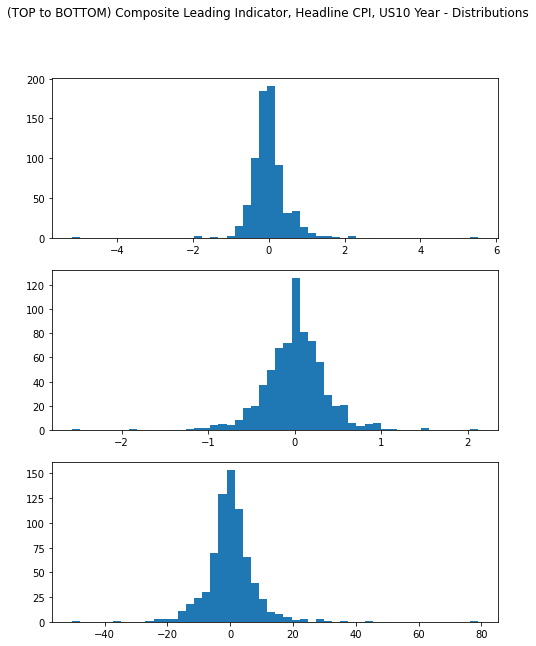

In [15]:
# Histogram plot to view distribution
fig, ax = plt.subplots(3, figsize=(8, 10))
fig.suptitle('(TOP to BOTTOM) Composite Leading Indicator, Headline CPI, US10 Year - Distributions')
ax[0].hist(data1['cli_roc'], bins=50)
ax[1].hist(data1['headcpi_roc'], bins=50)
ax[2].hist(data1['us10_roc'], bins=50)
plt.show()

In [16]:
# Dickey Fuller Test to Stationarity
dfuller(data1['cli_roc'])
print('\n')
dfuller(data1['headcpi_roc'])
print('\n')
dfuller(data1['us10_roc'])
print('\n')

Test-Statistic: -8.715744203826851
P-Value: 3.492380545484886e-14
Stationarity


Test-Statistic: -6.392696798125274
P-Value: 2.0869459634784497e-08
Stationarity


Test-Statistic: -7.8257541909912725
P-Value: 6.488688316768676e-12
Stationarity




In [17]:
# cli_roc = cli[['cli_roc']].copy()
# cli_mom = cli[['cli_%mom']].copy()
# cli_rocyoy = cli[['cli_roc%yoy']].copy()
# cli_yoy = cli[['cli_roc%yoy']].copy()

# X = np.concatenate([cli_roc, cli_mom, cli_rocyoy, cli_yoy])
# lengths = np.array([len(cli_roc), len(cli_mom), len(cli_rocyoy), len(cli_yoy)])

In [18]:
data1.columns

Index(['cli', 'headcpi', 'us10', 'dxy', 'btc', 'cli_', 'cli_roc', 'cli_mom',
       'cli_qoq', 'cli_yoy', 'headcpi_', 'headcpi_roc', 'headcpi_mom',
       'headcpi_qoq', 'headcpi_yoy', 'us10_', 'us10_roc', 'us10_mom',
       'us10_qoq', 'us10_yoy', 'dxy_', 'dxy_roc', 'dxy_mom', 'dxy_qoq',
       'dxy_yoy', 'regime'],
      dtype='object')

In [19]:
# data = data1.reset_index(drop=False)
# data['Date'] = data['Date'].apply(datetime.datetime.toordinal)

In [20]:
data1.tail()

,cli,headcpi,us10,dxy,btc,cli_,cli_roc,cli_mom,cli_qoq,cli_yoy,headcpi_,headcpi_roc,headcpi_mom,headcpi_qoq,headcpi_yoy,us10_,us10_roc,us10_mom,us10_qoq,us10_yoy,dxy_,dxy_roc,dxy_mom,dxy_qoq,dxy_yoy,regime
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,99.75359,263.161,1.26,90.88,45164.0,99.75359,0.458061,100.336717,101.041352,100.914817,263.161,0.301076,100.354649,100.856178,101.675656,1.26,31.399938,116.666667,144.827586,84.000000,90.88,-0.426308,100.331199,98.922390,92.611841,2.0
2021-03-01,100.05380,264.793,1.61,93.23,58763.7,100.05380,2.290244,100.300952,100.968188,103.252682,264.793,0.941372,100.620153,101.236045,102.637322,1.61,78.984963,127.777778,173.118280,185.057471,93.23,1.619796,102.585827,103.657994,94.124180,2.0
2021-04-01,100.29900,266.832,1.64,91.28,57720.3,100.29900,5.523112,100.245068,100.885315,109.115868,266.832,1.466064,100.770035,101.754560,104.153135,1.64,29.471544,101.863354,151.851852,248.484848,91.28,-2.083493,97.908399,100.772798,92.183397,2.0
2021-05-01,100.41510,268.551,1.62,90.03,37298.6,100.41510,-1.443027,100.115754,100.663144,107.552603,268.551,0.739790,100.644226,102.048176,104.926507,1.62,-2.730797,98.780488,128.571429,241.791045,90.03,-0.689777,98.630587,99.064701,91.549725,3.0
2021-06-01,100.66020,270.981,1.52,92.44,35026.9,100.66020,-1.941800,100.244087,100.606074,105.484292,270.981,0.378596,100.904856,102.336920,105.324508,1.52,-14.948264,93.827160,94.409938,208.219178,92.44,3.612416,102.676885,99.152633,94.917343,3.0


In [24]:
data1.describe()

,cli,headcpi,us10,dxy,btc,cli_,cli_roc,cli_mom,cli_qoq,cli_yoy,headcpi_,headcpi_roc,headcpi_mom,headcpi_qoq,headcpi_yoy,us10_,us10_roc,us10_mom,us10_qoq,us10_yoy,dxy_,dxy_roc,dxy_mom,dxy_qoq,dxy_yoy,regime
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,99.958635,133.356966,5.960828,96.922579,910.913379,99.958635,0.010868,100.003845,100.012658,100.023437,133.356966,0.004966,100.305264,100.917333,103.718534,5.960828,0.129622,100.027385,100.292216,100.202935,96.922579,-0.007195,100.021915,100.066211,100.297654,2.543448
std,1.565079,75.456844,2.958468,13.326991,4697.522268,1.565079,0.504109,0.333864,0.820839,2.086325,75.456844,0.367974,0.315986,0.808610,2.827513,2.958468,8.188861,5.453697,11.315200,21.851242,13.326991,3.374168,2.411728,4.318667,8.795974,1.174006
min,91.919720,29.810000,0.620000,71.800000,0.100000,91.919720,-5.175279,94.858542,92.876459,92.455658,29.810000,-2.569226,98.229452,96.583012,98.041239,0.620000,-50.281628,58.000000,37.500000,26.086957,71.800000,-22.417316,91.853958,86.659227,71.741163,0.000000
25%,99.184860,56.000000,3.930000,88.530000,0.100000,99.184860,-0.222069,99.872919,99.618960,98.842515,56.000000,-0.192885,100.130124,100.492005,101.796020,3.930000,-3.452041,97.568389,94.513274,86.868687,88.530000,-1.630708,98.801017,97.737056,94.918811,1.000000
50%,100.131800,135.100000,5.720000,96.922579,0.100000,100.131800,-0.025408,100.004906,100.019231,100.197576,135.100000,-0.007540,100.264317,100.774443,102.982456,5.720000,0.156546,100.000000,100.634249,100.479616,96.922579,0.000000,100.000000,100.000000,100.000000,3.000000
75%,100.960700,201.300000,7.710000,100.450000,0.100000,100.960700,0.185916,100.136257,100.392280,101.007041,201.300000,0.201495,100.457666,101.201923,104.528986,7.710000,3.513621,102.698651,105.411255,110.526316,100.450000,1.653539,100.997835,102.041021,105.686546,4.000000
max,104.076400,270.981000,15.320000,160.410000,58763.700000,104.076400,5.523112,102.209649,105.596242,109.115868,270.981000,2.120709,101.809955,104.161248,114.592275,15.320000,78.984963,127.777778,173.118280,248.484848,160.410000,21.574357,124.078416,124.078416,129.786245,4.000000


## Fit the Hidden Markov Model

In [21]:
data1.columns

Index(['cli', 'headcpi', 'us10', 'dxy', 'btc', 'cli_', 'cli_roc', 'cli_mom',
       'cli_qoq', 'cli_yoy', 'headcpi_', 'headcpi_roc', 'headcpi_mom',
       'headcpi_qoq', 'headcpi_yoy', 'us10_', 'us10_roc', 'us10_mom',
       'us10_qoq', 'us10_yoy', 'dxy_', 'dxy_roc', 'dxy_mom', 'dxy_qoq',
       'dxy_yoy', 'regime'],
      dtype='object')

In [297]:
# Using hmmlearn package
# encoder = LabelEncoder()
X1 = data1['cli_roc']
X2 = data1['headcpi_roc']
X1 = X1.to_numpy().reshape(-1, 1)
X2 = X2.to_numpy().reshape(-1, 1)

# X3 = data['us10_roc']
X3 = data1['regime'].to_numpy().reshape(-1,1)

# X = np.concatenate([X1, X2])
# lengthsX = np.array([len(X1), len(X2)])

# cols = ['cli_roc', 'headcpi_roc', 'regime']
# encoder = encoder.fit(data['regime'])
# X3 = [encoder.transform(X) for c in X3]

In [298]:
hidden_states = 4
model1 = hmm.GaussianHMM(n_components=hidden_states, covariance_type="diag", n_iter=1000)
# model2 = hmm.GaussianHMM(n_components=hidden_states, covariance_type="diag", n_iter=1000)
model1.fit(X3)

GaussianHMM(n_components=4, n_iter=1000)

In [299]:
Z = model1.predict(X3)
Z

array([2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 2,
       2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 3, 3, 3, 1, 1, 1, 0, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 3, 1, 3, 3, 3, 1, 1, 0, 2, 0, 0, 2, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 3, 1, 3,
       1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 2, 2, 2, 2, 0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 3, 1, 3, 1, 3, 0, 0, 0, 0, 0, 0, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2,

In [300]:
gamma = model1.predict_proba(X3)
gamma

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00, 1.07710664e-11, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.05684331e-38, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.93825140e-39, 1.00000000e+00]])

In [301]:
print(Z.shape)

(725,)


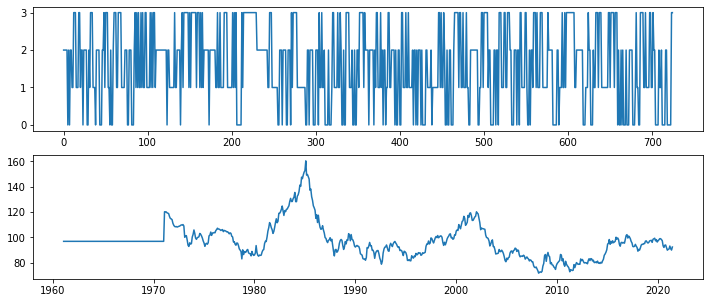

In [338]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(data1['dxy']);

In [339]:
print("Transition Matrix")
print(model1.transmat_)

# setting transmition matrix manually
# State 0 --> State 0 = 96%
# State 1 --> State 0 = 7.8%
# State 0 --> State 1 = 3.7%
# State 1 --> State 1 = 92%

# State 0
# Deflation --> Deflation = 56%
# Deflation --> Goldilocks = 7%
# Deflation --> Inflation = 33%
# Deflation --> Reflation = 3.4%

# State 1
# Goldi --> Deflation = 5.6%
# Goldi --> Goldilocks = 61.7%
# Goldi --> Inflation = 2.5%
# Goldi --> Reflation = 30%

#State 2
# Inflation --> Deflation = 37%
# Inflation --> Goldilocks = 4.2%
# Inflation --> Inflation = 57%
# Inflation --> Reflation = 1%

# State 3
# Reflation --> Deflation = 5%
# Reflation --> Goldilocks = 38%
# Reflation --> Inflation = 6.6%
# Reflation --> Reflation = 50%

Transition Matrix
[[0.50364964 0.05109489 0.37956204 0.06569343]
 [0.03448276 0.56157635 0.06896552 0.33497537]
 [0.30102041 0.05612245 0.61734694 0.0255102 ]
 [0.0106383  0.37765957 0.04255319 0.56914894]]


In [340]:
for i in range(model1.n_components):
    print("# {0} hidden state".format(i))
    print("mean = ", model1.means_[i])
    print("var = ", np.diag(model1.covars_[i]))

# 0 hidden state
mean =  [2.]
var =  [7.29927007e-05]
# 1 hidden state
mean =  [4.]
var =  [4.92610837e-05]
# 2 hidden state
mean =  [0.9744898]
var =  [0.02491045]
# 3 hidden state
mean =  [3.]
var =  [5.29100529e-05]


In [341]:
data1['us10_roc'].shape

(725,)

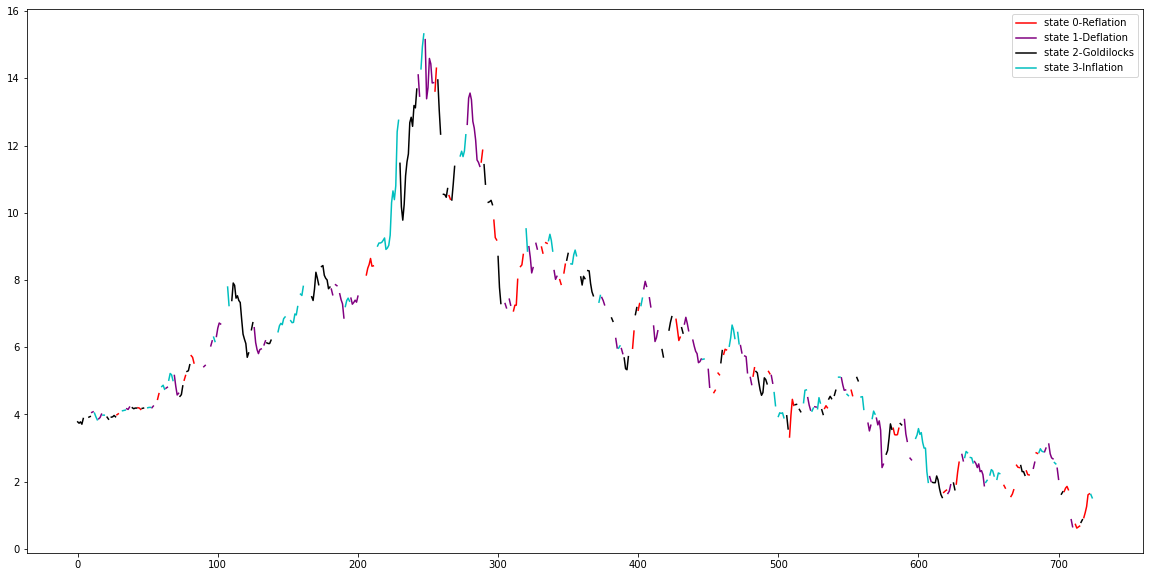

In [379]:
fig, ax = plt.subplots(figsize=(20, 10))

roc0 = np.empty(len(Z))
roc1 = np.empty(len(Z))
roc2 = np.empty(len(Z))
roc3 = np.empty(len(Z))
roc0[:] = np.nan
roc1[:] = np.nan
roc2[:] = np.nan
roc3[:] = np.nan

roc0[Z == 0] = data1['us10_'][Z == 0]
roc1[Z == 1] = data1['us10_'][Z == 1]
roc2[Z == 2] = data1['us10_'][Z == 2]
roc3[Z == 3] = data1['us10_'][Z == 3]

plt.plot(roc0, label='state 0-Reflation', color="red")
plt.plot(roc1, label='state 1-Deflation', color="purple")
plt.plot(roc2, label='state 2-Goldilocks', color="black")
plt.plot(roc3, label='state 3-Inflation', color="c")
plt.legend();

In [366]:
model1.transmat_ 

array([[0.50364964, 0.05109489, 0.37956204, 0.06569343],
       [0.03448276, 0.56157635, 0.06896552, 0.33497537],
       [0.30102041, 0.05612245, 0.61734694, 0.0255102 ],
       [0.0106383 , 0.37765957, 0.04255319, 0.56914894]])

In [199]:
pickle.dump(model1, open('HMM_model.pkl', 'wb'))

In [200]:
# run inference again
# Z = model1.predict(X1)

In [208]:
# Checking that 'file'.plk is not empty
import os

scores = {} # scores is an empty dict already

if os.path.getsize('HMM_model.pkl') > 0:      
    with open('HMM_model.pkl', "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        scores = unpickler.load()
print(scores)

GaussianHMM(n_components=4, n_iter=1000)


In [22]:
model1 = pickle.load(open('HMM_model.pkl', 'rb'))

In [204]:
X_dxy = dxy_df['dxy'].to_numpy().reshape(-1,1)